<a href="https://colab.research.google.com/github/orlandoalexander/Moda-Personal-Assistant/blob/google_cloud/Api_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install google-cloud-aiplatform

In [25]:
from google.cloud import aiplatform
from google.cloud import bigquery


import tensorflow as tf
import numpy as np
from PIL import Image
from keras.applications.mobilenet import preprocess_input
from sys import getsizeof
import matplotlib.pyplot as plt
import requests
from io import BytesIO


# Test model endpoints:

In [18]:
PROJECT_NUMBER = "530352962003"
ENDPOINT_ID = "4451214495376736256"
endpoint = aiplatform.Endpoint(
    endpoint_name=f"projects/{PROJECT_NUMBER}/locations/us-central1/endpoints/{ENDPOINT_ID}")

In [3]:
from google.colab import auth
auth.authenticate_user()

# https://cloud.google.com/resource-manager/docs/creating-managing-projects
project_id = 'lewagonbootcamp-371116'
!gcloud config set project {project_id}

Updated property [core/project].


In [4]:
classes = {
  "section": [
    "upper",
    "lower",
    "full body",
    "outfit"
  ],
  "category": [
    "Baggy_Pants",
    "Blouses",
    "Cardigans",
    "Dresses",
    "Graphic_Tees",
    "Jackets",
    "Joggers",
    "Pants",
    "Rompers",
    "Shirts",
    "Shorts",
    "Skirts",
    "Suiting",
    "Sweaters",
    "Tees"
  ],
  "design": [
    "floral",
    "graphic",
    "striped",
    "embroidered",
    "pleated",
    "solid",
    "lattice"
  ],
  "sleeves": [
    "long_sleeve",
    "short_sleeve",
    "sleeveless"
  ],
  "length": [
    "maxi_length",
    "mini_length"
  ],
  "neckline": [
    "crew_neckline",
    "v_neckline",
    "square_neckline",
    "no_neckline"
  ],
  "fabric": [
    "denim",
    "chiffon",
    "cotton",
    "leather",
    "faux",
    "knit"
  ],
  "fit": [
    "tight",
    "loose",
    "conventional"
  ]
}


In [5]:
def get_pad_color(image):
  left = image[:,0]
  right = image[:,-1]
  edge_color = int(np.concatenate((left, right)).mean())
  mean_color = (edge_color,edge_color)
  return mean_color

https://theleatherlaundry.com/blog/wp-content/uploads/2015/07/f94fb154474b8adcb921c9aa12e59f5a.jpg
tf.Tensor(3, shape=(), dtype=int64)
leather
[('leather', 0.912330627), ('chiffon', 0.0392686203), ('cotton', 0.0291597676), ('knit', 0.013194602), ('denim', 0.00501427613), ('faux', 0.00103221892)]


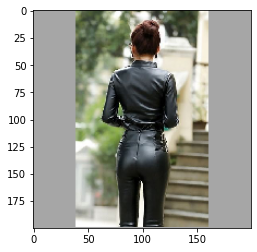

In [24]:
model = 'fabric'
url = input()
response = requests.get(url)
im = Image.open(BytesIO(response.content))
IMAGE_SIZE = (200,200)
im = np.array(im)

if im.shape[0] > im.shape[1]:
    scale = (IMAGE_SIZE[1]-1)/im.shape[0]
else:
    scale = (IMAGE_SIZE[0]-1)/im.shape[1]
scale_x, scale_y = (scale * dim for dim in im.shape[:-1])
x, y = np.ogrid[0:scale_x, 0:scale_y]

im = im[(x//scale).astype(int), (y//scale).astype(int)]

if im.shape[0] % 2 == 0:
    ax0_pad_left = ax0_pad_right = int((IMAGE_SIZE[1] - im.shape[0])/2)
else:
    dif = (IMAGE_SIZE[1] - im.shape[0])
    ax0_pad_left = int(dif/2)
    ax0_pad_right=0
    if dif > 0:
        ax0_pad_right = ax0_pad_left + 1

if im.shape[1] % 2 == 0:
    ax1_pad_left = ax1_pad_right = int((IMAGE_SIZE[0] - im.shape[1])/2)
else:
    dif = (IMAGE_SIZE[0] - im.shape[1])
    ax1_pad_left = int(dif/2)
    ax1_pad_right=0
    if dif > 0:
        ax1_pad_right = ax1_pad_left + 1


pad_color = get_pad_color(im)

cropped_pad_array = np.pad(im,pad_width=((ax0_pad_left, ax0_pad_right),(ax1_pad_left, ax1_pad_right),(0, 0)),constant_values=pad_color) # pad image with white background


im = preprocess_input(cropped_pad_array)
plt.imshow(cropped_pad_array)

x_test = im.astype(np.float32).tolist()
result = endpoint.predict(instances=[x_test]).predictions

# post process result
predicted_class = tf.math.argmax(result[0], axis=-1)
print(predicted_class)
print(classes[model][predicted_class])
res = [(classes[model][index],val) for index, val in enumerate(result[0])]
res.sort(key=lambda x: x[1],reverse=True)
print(res)